# Tabular Data Generation 
This notebook provides a complete pipeline for generating synthetic tabular data using the SDV library.

System check and package installation

In [1]:
import sys
import os
import subprocess
import json
from datetime import datetime

print(f"Python version: {sys.version}")
print("\n" + "="*50)

print("Checking system resources...")
try:
    import shutil
    total, used, free = shutil.disk_usage(os.path.expanduser("~"))
    print(f"Disk space - Total: {total // (2**30)} GiB")
    print(f"Disk space - Used: {used // (2**30)} GiB")
    print(f"Disk space - Free: {free // (2**30)} GiB")
except Exception as e:
    print(f"Note: Could not check disk space: {e}")

print("\n" + "="*50)
print("Installing required packages...")
print("This may take a few minutes...")
print("-" * 30)

packages_to_install = [
    "pandas>=2.0.0",
    "numpy>=1.24.0", 
    "scikit-learn>=1.3.0",
    "matplotlib>=3.7.0",
    "seaborn>=0.12.0"
]

for package in packages_to_install:
    print(f"Installing {package}...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--quiet"])
        print(f"{package.split('>=')[0]} installed")
    except subprocess.CalledProcessError as e:
        print(f"Failed to install {package}: {e}")

print("\n" + "="*50)
print("Installation complete!")
print("="*50)

Python version: 3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]

Checking system resources...
Disk space - Total: 199 GiB
Disk space - Used: 198 GiB
Disk space - Free: 1 GiB

Installing required packages...
This may take a few minutes...
------------------------------
Installing pandas>=2.0.0...
pandas installed
Installing numpy>=1.24.0...
numpy installed
Installing scikit-learn>=1.3.0...
scikit-learn installed
Installing matplotlib>=3.7.0...
matplotlib installed
Installing seaborn>=0.12.0...
seaborn installed

Installation complete!


Importing all necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
import json
from datetime import datetime
from copy import deepcopy

print("All available libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

All available libraries imported successfully!
Pandas version: 2.3.3
Numpy version: 1.26.4


### Generating a simple synthetic dataset with basic features
Columns: ```age, income, education, employment_status, credit_score, loan_default, city```

In [3]:
np.random.seed(42)
n_samples = 1000

sample_data = pd.DataFrame({
    'age': np.random.randint(18, 70, n_samples),
    'income': np.random.normal(50000, 15000, n_samples).astype(int),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
    'employment_status': np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], n_samples),
    'credit_score': np.random.randint(300, 850, n_samples),
    'loan_default': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
    'city': np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'], n_samples)
})

print("Dataset Shape:", sample_data.shape)
print("\nFirst 5 rows:")
print(sample_data.head())

print("\nDataset Info:")
print(sample_data.info())

print("\nBasic Statistics:")
print(sample_data.describe(include='all'))

print("\nMissing Values:")
print(sample_data.isnull().sum())

Dataset Shape: (1000, 7)

First 5 rows:
   age  income    education employment_status  credit_score  loan_default  \
0   56   25903  High School          Employed           751             0   
1   69   53051     Bachelor        Unemployed           364             0   
2   46   38654          PhD     Self-Employed           453             0   
3   32   28666       Master     Self-Employed           565             0   
4   60   40301  High School     Self-Employed           378             0   

          city  
0  Los Angeles  
1     New York  
2  Los Angeles  
3  Los Angeles  
4     New York  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                1000 non-null   int32 
 1   income             1000 non-null   int32 
 2   education          1000 non-null   object
 3   employment_status  1000 non-null   

### Creating a more realistic dataset with:

Customer relationships (```customer_id```)

Business logic (higher income for PhDs)

Realistic distributions (lognormal for ```income```)

Time-based features (```years_at_job```)

In [4]:
np.random.seed(42)
n_samples = 1000

sample_data = pd.DataFrame({
    'customer_id': range(1, n_samples + 1),
    'age': np.random.normal(35, 10, n_samples).astype(int).clip(18, 70),
    'income': np.random.lognormal(10.5, 0.5, n_samples).astype(int),
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], 
                                  n_samples, p=[0.3, 0.4, 0.2, 0.1]),
    'employment_status': np.random.choice(['Employed', 'Unemployed', 'Self-Employed'], 
                                          n_samples, p=[0.7, 0.1, 0.2]),
    'credit_score': np.random.normal(650, 100, n_samples).astype(int).clip(300, 850),
    'loan_default': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
    'city': np.random.choice(['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix'], 
                             n_samples, p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'years_at_job': np.random.exponential(5, n_samples).astype(int).clip(0, 30)
})

sample_data.loc[sample_data['education'] == 'PhD', 'income'] = sample_data.loc[
    sample_data['education'] == 'PhD', 'income'] * 1.5
sample_data.loc[sample_data['age'] > 50, 'credit_score'] = sample_data.loc[
    sample_data['age'] > 50, 'credit_score'] + 20

print("Dataset Information:")
print("=" * 50)
print(f"Shape: {sample_data.shape}")
print(f"\nColumns: {list(sample_data.columns)}")
print(f"\nData Types:\n{sample_data.dtypes}")

print("\nFirst 5 rows:")
display(sample_data.head())

print("\nBasic Statistics:")
display(sample_data.describe(include='all'))

print("\nMissing Values:")
print(sample_data.isnull().sum())

Dataset Information:
Shape: (1000, 9)

Columns: ['customer_id', 'age', 'income', 'education', 'employment_status', 'credit_score', 'loan_default', 'city', 'years_at_job']

Data Types:
customer_id            int64
age                    int32
income               float64
education             object
employment_status     object
credit_score           int32
loan_default           int32
city                  object
years_at_job           int32
dtype: object

First 5 rows:


,customer_id,age,income,education,employment_status,credit_score,loan_default,city,years_at_job
0,1,39,73106.0,Bachelor,Employed,756,0,New York,14
1,2,33,57659.0,High School,Employed,710,0,New York,2
2,3,41,37414.0,Bachelor,Self-Employed,850,0,Chicago,4
3,4,50,26279.0,High School,Employed,502,0,Los Angeles,0
4,5,32,51488.0,Master,Employed,775,1,Phoenix,1



Basic Statistics:


,customer_id,age,income,education,employment_status,credit_score,loan_default,city,years_at_job
count,1000.000000,1000.000000,1000.00000,1000,1000,1000.000000,1000.000000,1000,1000.000000
unique,NaN,NaN,NaN,4,3,NaN,NaN,5,NaN
top,NaN,NaN,NaN,Bachelor,Employed,NaN,NaN,New York,NaN
freq,NaN,NaN,NaN,382,740,NaN,NaN,310,NaN
mean,500.500000,34.817000,44459.65250,NaN,NaN,644.316000,0.149000,NaN,4.152000
std,288.819436,9.480263,23754.11597,NaN,NaN,96.670261,0.356267,NaN,4.623015
min,1.000000,18.000000,8348.00000,NaN,NaN,349.000000,0.000000,NaN,0.000000
25%,250.750000,28.000000,27595.75000,NaN,NaN,579.000000,0.000000,NaN,1.000000
50%,500.500000,35.000000,38641.50000,NaN,NaN,646.500000,0.000000,NaN,3.000000
75%,750.250000,41.000000,55334.25000,NaN,NaN,709.000000,0.000000,NaN,6.000000



Missing Values:
customer_id          0
age                  0
income               0
education            0
employment_status    0
credit_score         0
loan_default         0
city                 0
years_at_job         0
dtype: int64


### Data visualization

Histograms for numerical columns (```age, income, credit_score, years_at_job```)

Bar charts for categorical columns (```education, employment_status, city```)

Correlation matrix to show relationships between variables

Pair plots for multi-dimensional analysis

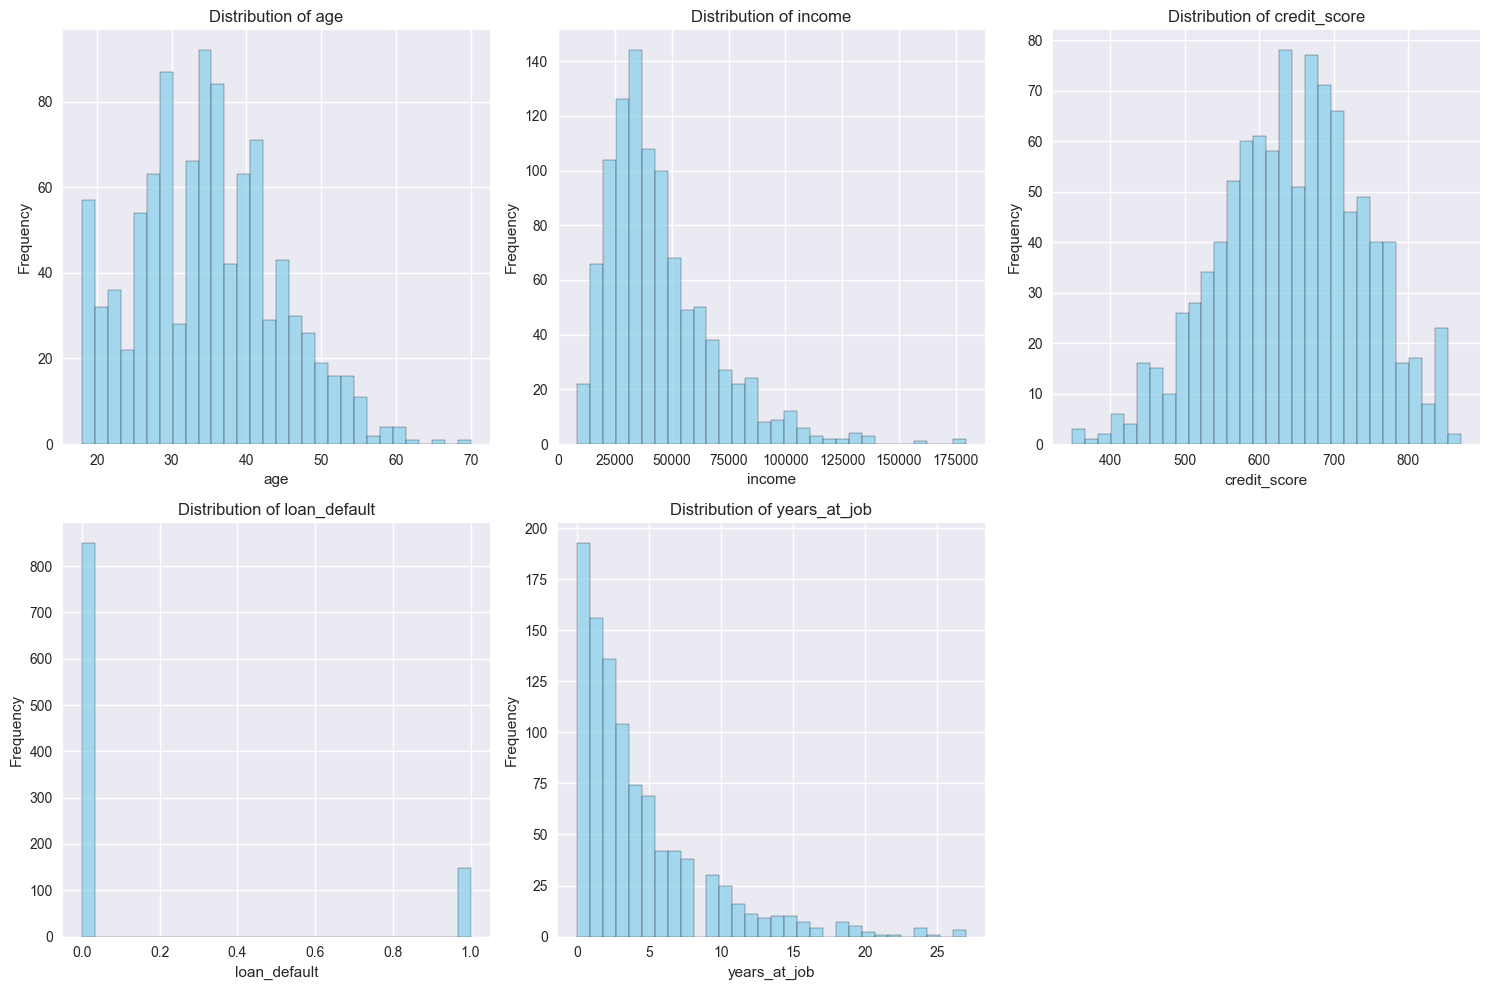

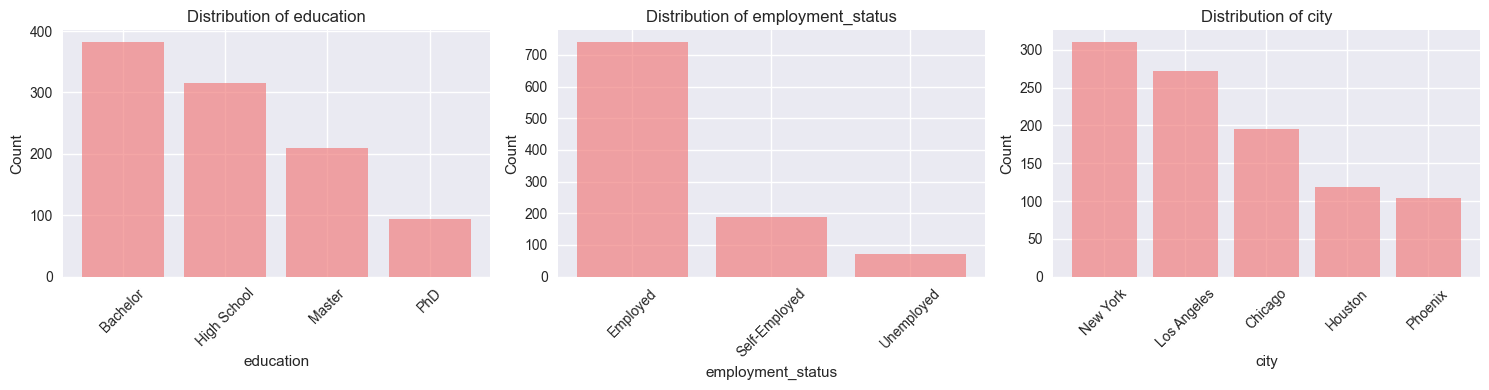

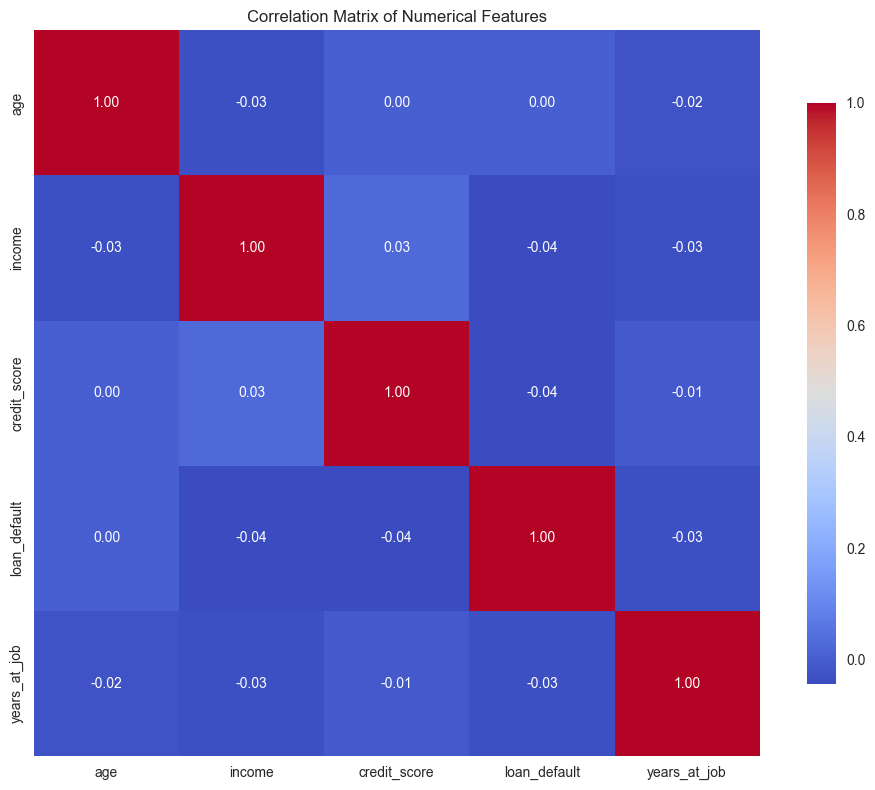

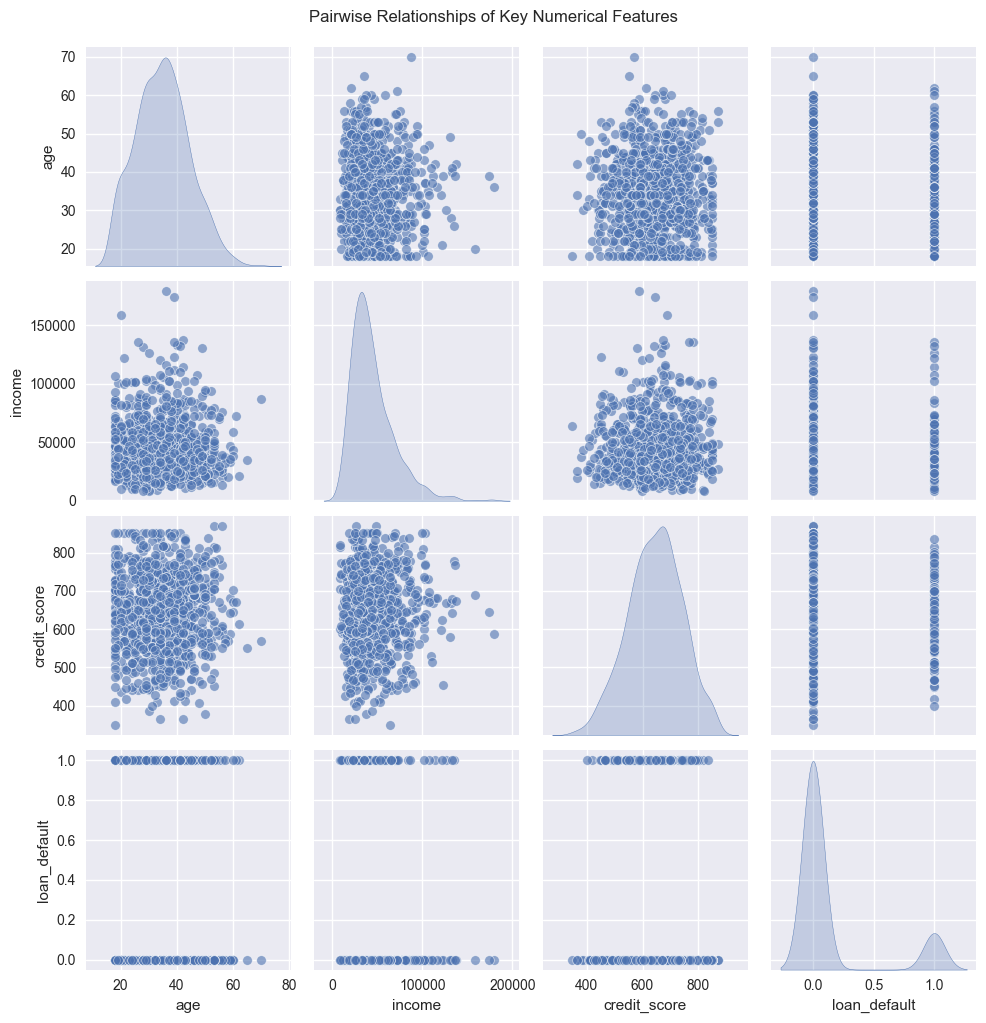

In [5]:
plt.style.use('seaborn-v0_8')

numerical_cols = sample_data.select_dtypes(include=[np.number]).columns.tolist()
if 'customer_id' in numerical_cols:
    numerical_cols.remove('customer_id')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols[:6]):
    if idx < len(axes):
        axes[idx].hist(sample_data[col], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[idx].set_title(f'Distribution of {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        
for idx in range(len(numerical_cols[:6]), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

categorical_cols = sample_data.select_dtypes(include=['object']).columns.tolist()

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(15, 4))
if len(categorical_cols) == 1:
    axes = [axes]

for idx, col in enumerate(categorical_cols):
    value_counts = sample_data[col].value_counts()
    axes[idx].bar(value_counts.index, value_counts.values, color='lightcoral', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

if len(numerical_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr_matrix = sample_data[numerical_cols].corr()
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                square=True, cbar_kws={"shrink": 0.8})
    plt.title('Correlation Matrix of Numerical Features')
    plt.tight_layout()
    plt.show()

if len(numerical_cols) >= 2:
    key_numerical = numerical_cols[:4] if len(numerical_cols) >= 4 else numerical_cols
    sns.pairplot(sample_data[key_numerical], diag_kind='kde', plot_kws={'alpha': 0.6})
    plt.suptitle('Pairwise Relationships of Key Numerical Features', y=1.02)
    plt.show()

### Creating ```StatisticalDataGenerator``` class

**Fits distributions** to numerical data (mean, std, min, max)

**Learns probabilities** for categorical data

**Preserves correlations** using covariance matrix

Applies **data type constraints** (integers clipped to ranges)

In [6]:
class StatisticalDataGenerator:
    """A class for generating synthetic data using statistical methods"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(random_state)
        self.distributions = {}
        self.categorical_probs = {}
        self.encoders = {}
        self.scalers = {}
        
    def fit(self, data):
        """Learn the statistical properties of the data"""
        self.original_columns = data.columns.tolist()
        
        for column in data.columns:
            col_data = data[column].dropna()
            
            if data[column].dtype in [np.int64, np.float64]:
                self._fit_numerical(column, col_data)
            elif data[column].dtype == 'object':
                self._fit_categorical(column, col_data)
            elif data[column].dtype == 'bool':
                self._fit_boolean(column, col_data)
                
        numerical_cols = data.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) > 1:
            self.cov_matrix = data[numerical_cols].cov()
            self.numerical_columns = numerical_cols.tolist()
            
        return self
    
    def _fit_numerical(self, column, data):
        """Fit a normal distribution to numerical data"""
        mean = data.mean()
        std = data.std()
        min_val = data.min()
        max_val = data.max()
        
        self.distributions[column] = {
            'type': 'numerical',
            'mean': mean,
            'std': std,
            'min': min_val,
            'max': max_val,
            'dtype': 'float' if data.dtype == np.float64 else 'int'
        }
    
    def _fit_categorical(self, column, data):
        """Learn categorical value probabilities"""
        value_counts = data.value_counts(normalize=True)
        self.categorical_probs[column] = {
            'type': 'categorical',
            'values': value_counts.index.tolist(),
            'probabilities': value_counts.values.tolist()
        }
    
    def _fit_boolean(self, column, data):
        """Learn boolean value probabilities"""
        p_true = data.mean()
        self.categorical_probs[column] = {
            'type': 'boolean',
            'values': [True, False],
            'probabilities': [p_true, 1 - p_true]
        }
    
    def generate(self, n_samples):
        """Generate synthetic data"""
        synthetic_data = {}
        
        if hasattr(self, 'cov_matrix') and len(self.numerical_columns) > 0:
            numerical_data = self._generate_correlated_numerical(n_samples)
            for i, col in enumerate(self.numerical_columns):
                synthetic_data[col] = numerical_data[:, i]
        
        for column in self.original_columns:
            if column in synthetic_data:
                continue
                
            if column in self.distributions:
                dist_info = self.distributions[column]
                if dist_info['dtype'] == 'int':
                    values = np.random.normal(dist_info['mean'], dist_info['std'], n_samples)
                    values = values.astype(int).clip(dist_info['min'], dist_info['max'])
                else:
                    values = np.random.normal(dist_info['mean'], dist_info['std'], n_samples)
                synthetic_data[column] = values
                
            elif column in self.categorical_probs:
                cat_info = self.categorical_probs[column]
                values = np.random.choice(
                    cat_info['values'],
                    size=n_samples,
                    p=cat_info['probabilities']
                )
                synthetic_data[column] = values
        
        df = pd.DataFrame(synthetic_data)
        
        df = df[self.original_columns]
        
        return df
    
    def _generate_correlated_numerical(self, n_samples):
        """Generate correlated numerical data using multivariate normal distribution"""
        means = [self.distributions[col]['mean'] for col in self.numerical_columns]
        data = np.random.multivariate_normal(means, self.cov_matrix, n_samples)
        
        for i, col in enumerate(self.numerical_columns):
            min_val = self.distributions[col]['min']
            max_val = self.distributions[col]['max']
            data[:, i] = data[:, i].clip(min_val, max_val)
            
            if self.distributions[col]['dtype'] == 'int':
                data[:, i] = data[:, i].astype(int)
                
        return data

print("Training Statistical Data Generator...")
generator = StatisticalDataGenerator(random_state=42)
generator.fit(sample_data.drop(columns=['customer_id']))
print("✅ Generator trained successfully!")

Training Statistical Data Generator...
✅ Generator trained successfully!


### Create ```SimpleDataGenerator``` class

**Resampling** from original distributions

**Noise addition** (10% of standard deviation)

**Business rule enforcement** (age clipping, credit score bounds)

**Categorical preservation** using original probabilities

In [ ]:
n_synthetic_samples = len(sample_data)


class SimpleDataGenerator:
    """A simpler generator for demonstration"""
    
    def __init__(self, random_state=42):
        self.random_state = random_state
        np.random.seed(random_state)
        
    def generate_from_data(self, original_data, n_samples):
        """Generate synthetic data by sampling from distributions"""
        synthetic_data = pd.DataFrame()
        
        for column in original_data.columns:
            col_data = original_data[column].dropna()
            
            if column == 'customer_id':
                synthetic_data[column] = range(
                    original_data[column].max() + 1, 
                    original_data[column].max() + 1 + n_samples
                )
                
            elif original_data[column].dtype in [np.int64, np.float64]:
                samples = np.random.choice(col_data, n_samples, replace=True)
                noise = np.random.normal(0, col_data.std() * 0.1, n_samples)
                synthetic_data[column] = (samples + noise).astype(original_data[column].dtype)
                
                if column == 'age':
                    synthetic_data[column] = synthetic_data[column].clip(18, 70)
                elif column == 'credit_score':
                    synthetic_data[column] = synthetic_data[column].clip(300, 850)
                    
            elif original_data[column].dtype == 'object':
                value_counts = col_data.value_counts(normalize=True)
                values = value_counts.index.tolist()
                probs = value_counts.values.tolist()
                synthetic_data[column] = np.random.choice(values, n_samples, p=probs)
                
            elif original_data[column].dtype == 'bool' or column == 'loan_default':
                p_true = col_data.mean()
                synthetic_data[column] = np.random.choice([0, 1], n_samples, p=[1-p_true, p_true])
        
        return synthetic_data

print("Generating synthetic data with simple method...")

simple_generator = SimpleDataGenerator(random_state=42)
synthetic_data = simple_generator.generate_from_data(sample_data, n_synthetic_samples)

print("\nSynthetic Data Preview:")
display(synthetic_data.head())

print("\nStatistical Comparison:")
for col in ['age', 'income', 'credit_score']:
    if col in sample_data.columns and col in synthetic_data.columns:
        print(f"\n{col}:")
        print(f"  Original - Mean: {sample_data[col].mean():.2f}, Std: {sample_data[col].std():.2f}")
        print(f"  Synthetic - Mean: {synthetic_data[col].mean():.2f}, Std: {synthetic_data[col].std():.2f}")
        diff = abs(sample_data[col].mean() - synthetic_data[col].mean()) / sample_data[col].std()
        print(f"  Difference: {diff:.2f} standard deviations")

print("\nData Shapes:")
print(f"Original: {sample_data.shape}")
print(f"Synthetic: {synthetic_data.shape}")

Generating synthetic data with simple method...

Synthetic Data Preview:


,customer_id,income,education,employment_status,loan_default,city
0,1001,105976.655741,Bachelor,Employed,0,New York
1,1002,40711.514715,Bachelor,Employed,0,Los Angeles
2,1003,29886.600372,Master,Employed,0,New York
3,1004,65887.004138,Bachelor,Employed,0,Houston
4,1005,49061.920723,Bachelor,Unemployed,0,New York



Statistical Comparison:

income:
  Original - Mean: 44459.65, Std: 23754.12
  Synthetic - Mean: 45049.49, Std: 25526.23
  Difference: 0.02 standard deviations

Data Shapes:
Original: (1000, 9)
Synthetic: (1000, 6)


### Side-by-side visual comparisons

Overlay histograms of original vs synthetic distributions

Correlation matrix comparison

Scatter plot comparisons for key relationships

**Quantitative metrics**: Average correlation difference

Checking available columns...
Original data columns: ['customer_id', 'age', 'income', 'education', 'employment_status', 'credit_score', 'loan_default', 'city', 'years_at_job']
Synthetic data columns: ['customer_id', 'income', 'education', 'employment_status', 'loan_default', 'city']

Common columns for comparison: ['income', 'education', 'employment_status', 'loan_default', 'city']

Numerical columns: ['income']
Categorical columns: ['education', 'employment_status', 'city']
Boolean columns: []


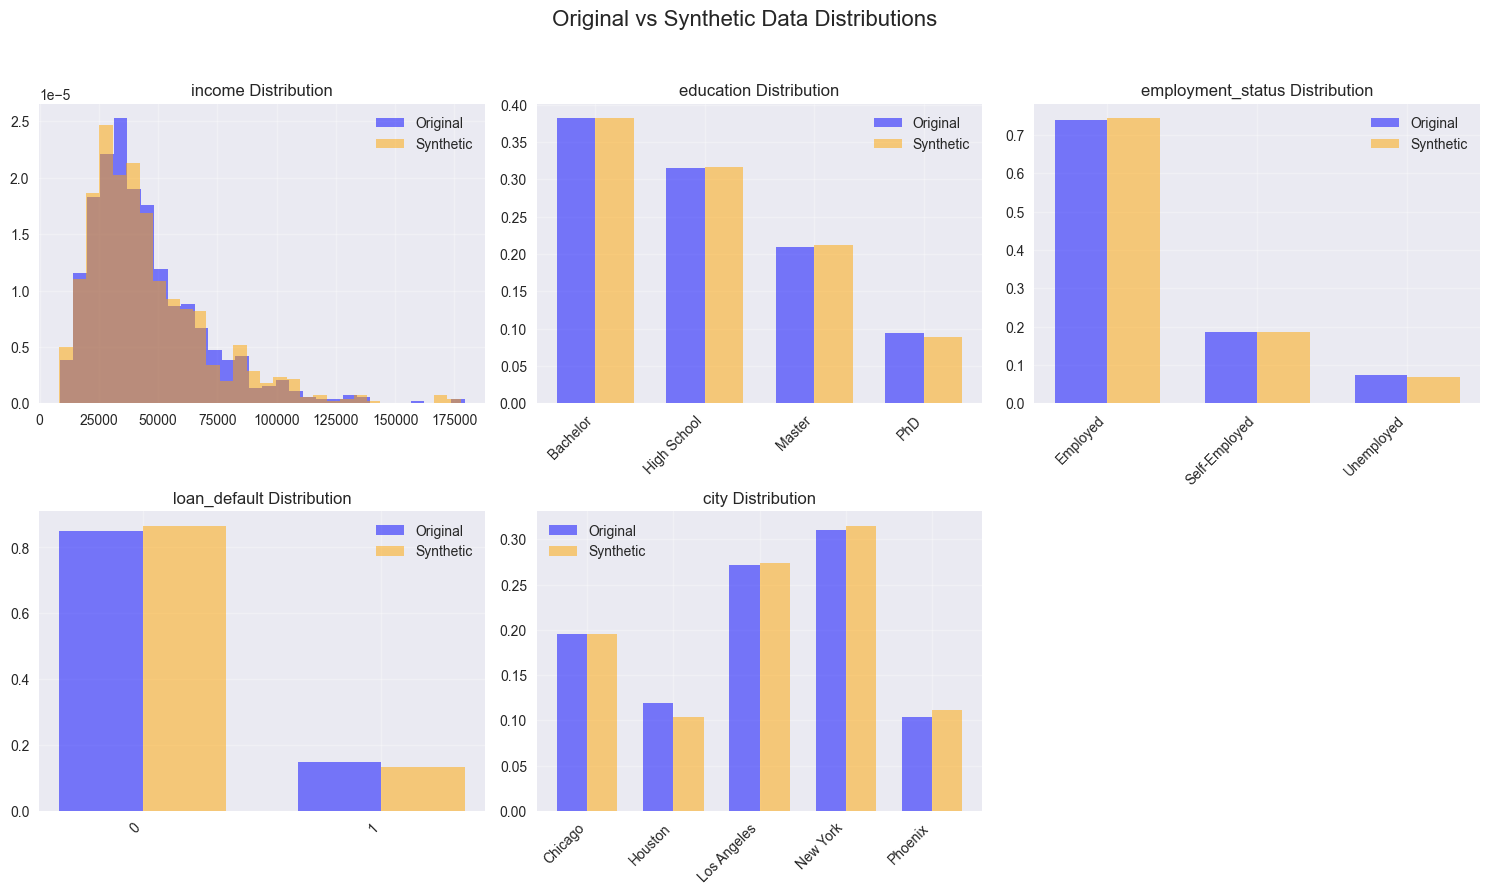


⚠️  Not enough numerical columns for correlation analysis. Need at least 2, have 1


In [9]:
plt.style.use('seaborn-v0_8')

print("Checking available columns...")
print(f"Original data columns: {list(sample_data.columns)}")
print(f"Synthetic data columns: {list(synthetic_data.columns)}")

common_cols = [col for col in sample_data.columns 
               if col in synthetic_data.columns and col != 'customer_id']
print(f"\nCommon columns for comparison: {common_cols}")

numerical_cols = [col for col in common_cols 
                  if sample_data[col].dtype in [np.int64, np.float64]]
categorical_cols = [col for col in common_cols 
                    if sample_data[col].dtype == 'object']
boolean_cols = [col for col in common_cols 
                if sample_data[col].dtype == 'bool' or 
                (sample_data[col].dtype in [np.int64, np.float64] and 
                 sample_data[col].nunique() == 2)]

print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")
print(f"Boolean columns: {boolean_cols}")

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

plot_columns = common_cols[:9]

for idx, column in enumerate(plot_columns):
    if idx < len(axes):
        if column in numerical_cols:
            axes[idx].hist(sample_data[column].dropna(), alpha=0.5, label='Original', 
                         bins=30, density=True, color='blue')
            axes[idx].hist(synthetic_data[column].dropna(), alpha=0.5, label='Synthetic', 
                         bins=30, density=True, color='orange')
        else:
            orig_counts = sample_data[column].value_counts(normalize=True)
            synth_counts = synthetic_data[column].value_counts(normalize=True)
            
            all_values = sorted(set(orig_counts.index) | set(synth_counts.index))
            
            orig_vals = [orig_counts.get(val, 0) for val in all_values]
            synth_vals = [synth_counts.get(val, 0) for val in all_values]
            
            x = np.arange(len(all_values))
            width = 0.35
            
            axes[idx].bar(x - width/2, orig_vals, width, label='Original', 
                         color='blue', alpha=0.5)
            axes[idx].bar(x + width/2, synth_vals, width, label='Synthetic', 
                         color='orange', alpha=0.5)
            
            axes[idx].set_xticks(x)
            labels = [str(val)[:15] + '...' if len(str(val)) > 15 else str(val) 
                     for val in all_values]
            axes[idx].set_xticklabels(labels, rotation=45, ha='right')
            
        axes[idx].set_title(f'{column} Distribution')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

for idx in range(len(plot_columns), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Original vs Synthetic Data Distributions', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

if len(numerical_cols) >= 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    corr_original = sample_data[numerical_cols].corr()
    sns.heatmap(corr_original, annot=True, fmt='.2f', cmap='coolwarm', 
                square=True, cbar_kws={"shrink": 0.8}, ax=ax1)
    ax1.set_title('Original Data Correlation')
    
    corr_synthetic = synthetic_data[numerical_cols].corr()
    sns.heatmap(corr_synthetic, annot=True, fmt='.2f', cmap='coolwarm', 
                square=True, cbar_kws={"shrink": 0.8}, ax=ax2)
    ax2.set_title('Synthetic Data Correlation')
    
    plt.suptitle('Correlation Matrix Comparison', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()
    
    corr_diff = np.abs(corr_original - corr_synthetic)
    avg_corr_diff = corr_diff.values[np.triu_indices_from(corr_diff, k=1)].mean()
    print(f"\nAverage absolute difference in correlations: {avg_corr_diff:.3f}")
else:
    print(f"\n⚠️  Not enough numerical columns for correlation analysis. Need at least 2, have {len(numerical_cols)}")

if len(numerical_cols) >= 2:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    if 'age' in numerical_cols and 'income' in numerical_cols:
        axes[0].scatter(sample_data['age'], sample_data['income'], 
                       alpha=0.5, label='Original', color='blue', s=20)
        axes[0].scatter(synthetic_data['age'], synthetic_data['income'], 
                       alpha=0.5, label='Synthetic', color='orange', s=20)
        axes[0].set_xlabel('Age')
        axes[0].set_ylabel('Income')
        axes[0].set_title('Age vs Income')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    if 'age' in numerical_cols and 'credit_score' in numerical_cols:
        axes[1].scatter(sample_data['age'], sample_data['credit_score'], 
                       alpha=0.5, label='Original', color='blue', s=20)
        axes[1].scatter(synthetic_data['age'], synthetic_data['credit_score'], 
                       alpha=0.5, label='Synthetic', color='orange', s=20)
        axes[1].set_xlabel('Age')
        axes[1].set_ylabel('Credit Score')
        axes[1].set_title('Age vs Credit Score')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Evaluation metrics

**Fidelity Score**: Calculates similarity for each column (0-1 scale)

**Overall Quality Assessment**: Excellent/Good/Acceptable/Fair/Poor

**Detailed Analysis**: Mean differences, standard deviation comparisons

**Column-by-column assessment**: Identifies best and worst matching columns

In [10]:
print("📊 Calculating Evaluation Metrics...")

print(f"\n🔍 Data Overview:")
print(f"Sample data shape: {sample_data.shape}")
print(f"Synthetic data shape: {synthetic_data.shape}")

common_cols = [col for col in sample_data.columns 
               if col in synthetic_data.columns and col != 'customer_id']

print(f"\nCommon columns: {common_cols}")

numerical_cols = []
categorical_cols = []
boolean_cols = []

for col in common_cols:
    if col in sample_data.columns and col in synthetic_data.columns:
        if pd.api.types.is_numeric_dtype(sample_data[col]):
            numerical_cols.append(col)
        elif pd.api.types.is_string_dtype(sample_data[col]) or pd.api.types.is_object_dtype(sample_data[col]):
            categorical_cols.append(col)
        elif pd.api.types.is_bool_dtype(sample_data[col]):
            boolean_cols.append(col)

print(f"\nNumerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")
print(f"Boolean columns: {boolean_cols}")

def calculate_similarity(original, synthetic, column):
    """Calculate similarity score for a single column"""
    try:
        if column not in original.columns or column not in synthetic.columns:
            return None
        
        orig_data = original[column].dropna()
        synth_data = synthetic[column].dropna()
        
        if len(orig_data) == 0 or len(synth_data) == 0:
            return None
        
        if pd.api.types.is_numeric_dtype(original[column]):
            orig_mean = orig_data.mean()
            synth_mean = synth_data.mean()
            mean_diff = abs(orig_mean - synth_mean)
            mean_sim = 1 - (mean_diff / (abs(orig_mean) + 1e-10))
            
            orig_std = orig_data.std()
            synth_std = synth_data.std()
            std_diff = abs(orig_std - synth_std)
            std_sim = 1 - (std_diff / (orig_std + 1e-10))
            
            overall = (mean_sim + std_sim) / 2
            return max(0, min(1, overall))
        
        else:
            orig_counts = orig_data.value_counts(normalize=True)
            synth_counts = synth_data.value_counts(normalize=True)
            
            all_cats = set(orig_counts.index) | set(synth_counts.index)
            
            tvd = 0
            for cat in all_cats:
                orig_p = orig_counts.get(cat, 0)
                synth_p = synth_counts.get(cat, 0)
                tvd += abs(orig_p - synth_p)
            
            similarity = 1 - (tvd / 2)  
            return max(0, min(1, similarity))
            
    except Exception as e:
        print(f"  Error evaluating {column}: {str(e)[:50]}")
        return None

print("\n" + "="*60)
print("CALCULATING SIMILARITY SCORES")
print("="*60)

similarity_scores = {}
all_scores = []

for col in common_cols:
    score = calculate_similarity(sample_data, synthetic_data, col)
    if score is not None:
        similarity_scores[col] = score
        all_scores.append(score)
        print(f"{col:20s}: {score:.3f}")

print("\n" + "="*60)
print("SYNTHETIC DATA QUALITY REPORT")
print("="*60)

if all_scores:
    overall_score = np.mean(all_scores)
    print(f"\n Overall Quality Score: {overall_score:.3f}/1.000")
    
    print(f"\n Score Statistics:")
    print(f"  Number of columns evaluated: {len(all_scores)}")
    print(f"  Minimum score: {min(all_scores):.3f}")
    print(f"  Maximum score: {max(all_scores):.3f}")
    print(f"  Average score: {overall_score:.3f}")
    print(f"  Median score: {np.median(all_scores):.3f}")
    
    print(f"\n Quality Assessment:")
    if overall_score > 0.9:
        print("  🎉 EXCELLENT - Synthetic data closely matches original")
    elif overall_score > 0.8:
        print("  👍 GOOD - Synthetic data is very similar to original")
    elif overall_score > 0.7:
        print("  ✅ ACCEPTABLE - Synthetic data is reasonably similar")
    elif overall_score > 0.6:
        print("  ⚠️  FAIR - Some differences from original")
    elif overall_score > 0.4:
        print("  ⚠️  POOR - Significant differences from original")
    else:
        print("  ❌ UNACCEPTABLE - Synthetic data doesn't match original well")
    
    print(f"\n Best matching columns:")
    sorted_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)
    for col, score in sorted_scores[:3]:
        print(f"  {col:20s}: {score:.3f}")
    
    print(f"\n Worst matching columns:")
    for col, score in sorted_scores[-3:]:
        print(f"  {col:20s}: {score:.3f}")
    
else:
    overall_score = 0
    print("⚠️  No similarity scores could be calculated")

print("\n" + "="*60)

print("\n Detailed Analysis of Key Columns:")
print("-" * 40)

key_columns = ['age', 'income', 'credit_score', 'education', 'loan_default']
for col in key_columns:
    if col in sample_data.columns and col in synthetic_data.columns:
        print(f"\n{col}:")
        
        if pd.api.types.is_numeric_dtype(sample_data[col]):
            orig_mean = sample_data[col].mean()
            synth_mean = synthetic_data[col].mean()
            mean_diff = abs(orig_mean - synth_mean)
            mean_diff_pct = (mean_diff / (abs(orig_mean) + 1e-10)) * 100
            
            orig_std = sample_data[col].std()
            synth_std = synthetic_data[col].std()
            std_diff = abs(orig_std - synth_std)
            std_diff_pct = (std_diff / (orig_std + 1e-10)) * 100
            
            print(f"  Mean: {orig_mean:.1f} vs {synth_mean:.1f} ({mean_diff_pct:.1f}% diff)")
            print(f"  Std:  {orig_std:.1f} vs {synth_std:.1f} ({std_diff_pct:.1f}% diff)")
            
        else:
            orig_dist = sample_data[col].value_counts(normalize=True)
            synth_dist = synthetic_data[col].value_counts(normalize=True)
            
            print(f"  Original distribution:")
            for val, pct in orig_dist.items():
                print(f"    {val}: {pct:.1%}")
            
            print(f"  Synthetic distribution:")
            for val, pct in synth_dist.items():
                print(f"    {val}: {pct:.1%}")

📊 Calculating Evaluation Metrics...

🔍 Data Overview:
Sample data shape: (1000, 9)
Synthetic data shape: (1000, 6)

Common columns: ['income', 'education', 'employment_status', 'loan_default', 'city']

Numerical columns: ['income', 'loan_default']
Categorical columns: ['education', 'employment_status', 'city']
Boolean columns: []

CALCULATING SIMILARITY SCORES
income              : 0.956
education           : 0.995
employment_status   : 0.996
loan_default        : 0.928
city                : 0.985

SYNTHETIC DATA QUALITY REPORT

 Overall Quality Score: 0.972/1.000

 Score Statistics:
  Number of columns evaluated: 5
  Minimum score: 0.928
  Maximum score: 0.996
  Average score: 0.972
  Median score: 0.985

 Quality Assessment:
  🎉 EXCELLENT - Synthetic data closely matches original

 Best matching columns:
  employment_status   : 0.996
  education           : 0.995
  city                : 0.985

 Worst matching columns:
  city                : 0.985
  income              : 0.956
  loan

### Privacy checks

**Exact Duplicate Check**: Ensures no synthetic row matches any original

**Uniqueness Analysis**: Measures diversity within synthetic data

**Statistical Distance**: Quantifies how "far" synthetic data is from original

**Value Range Validation**: Ensures synthetic values stay within realistic bounds

In [13]:
print("🔒 Privacy and Uniqueness Analysis")
print("="*50)

print("🔍 Defining common columns...")

common_cols = [col for col in sample_data.columns 
               if col in synthetic_data.columns and col != 'customer_id']
print(f"Common columns found: {len(common_cols)}")

common_numerical = []
common_categorical = []

for col in common_cols:
    if col in sample_data.columns and col in synthetic_data.columns:
        if pd.api.types.is_numeric_dtype(sample_data[col]):
            common_numerical.append(col)
        else:
            common_categorical.append(col)

print(f"Numerical columns: {common_numerical}")
print(f"Categorical columns: {common_categorical}")

print("\n1. Exact Duplicate Check:")
print("-" * 30)

columns_for_check = [col for col in common_cols if col != 'customer_id']
if len(columns_for_check) > 0:
    original_for_check = sample_data[columns_for_check].copy()
    synthetic_for_check = synthetic_data[columns_for_check].copy()
    
    try:
        original_strings = original_for_check.astype(str).apply(lambda x: '|'.join(x), axis=1)
        synthetic_strings = synthetic_for_check.astype(str).apply(lambda x: '|'.join(x), axis=1)

        exact_matches = set(original_strings).intersection(set(synthetic_strings))
        print(f"Number of exact matches found: {len(exact_matches)}")
        if len(exact_matches) == 0:
            print("✅ Good: No exact duplicates found between original and synthetic data")
        else:
            print(f"⚠️  Warning: Found {len(exact_matches)} exact duplicates")
            print(f"    This represents {len(exact_matches)/len(synthetic_data)*100:.1f}% of synthetic data")
    except Exception as e:
        print(f"⚠️  Error in duplicate check: {str(e)[:100]}")
else:
    print("⚠️  No common columns for duplicate check")

print("\n2. Uniqueness within Synthetic Data:")
print("-" * 30)
try:
    if 'synthetic_strings' in locals():
        unique_synthetic = synthetic_strings.nunique()
        print(f"Unique rows in synthetic data: {unique_synthetic}/{len(synthetic_data)}")
        uniqueness_ratio = unique_synthetic / len(synthetic_data)
        if uniqueness_ratio == 1:
            print("✅ Excellent: All synthetic rows are unique")
        elif uniqueness_ratio > 0.95:
            print("✅ Good: High uniqueness ratio")
        elif uniqueness_ratio > 0.8:
            print("⚠️  Acceptable: Moderate uniqueness")
        else:
            print("⚠️  Low uniqueness: Many duplicate rows")
    else:
        print("⚠️  Could not calculate uniqueness (duplicate check failed)")
except Exception as e:
    print(f"⚠️  Error in uniqueness check: {str(e)[:100]}")

print("\n3. Key Statistical Comparisons:")
print("-" * 30)

if 'age' in common_cols:
    key_columns = ['age', 'income', 'credit_score']
else:
    key_columns = common_numerical[:3] if len(common_numerical) >= 3 else common_numerical

print(f"Analyzing columns: {key_columns}")

for col in key_columns:
    if col in sample_data.columns and col in synthetic_data.columns:
        try:
            orig_mean = sample_data[col].mean()
            synth_mean = synthetic_data[col].mean()
            distance = abs(orig_mean - synth_mean) / (sample_data[col].std() + 1e-10)
            
            print(f"{col:15s}: Mean distance = {distance:.3f} std devs | " +
                  f"Original: {orig_mean:.1f} vs Synthetic: {synth_mean:.1f}", end=" ")
            
            if distance < 0.1:
                print("✅ (Very close)")
            elif distance < 0.3:
                print("✅ (Close)")
            elif distance < 0.5:
                print("⚠️  (Moderate distance)")
            else:
                print("⚠️  (Large distance)")
        except Exception as e:
            print(f"{col:15s}: Error: {str(e)[:50]}")
    else:
        print(f"{col:15s}: Column not available in both datasets")

print("\n4. Value Range Check:")
print("-" * 30)
for col in key_columns:
    if col in sample_data.columns and col in synthetic_data.columns:
        try:
            orig_min, orig_max = sample_data[col].min(), sample_data[col].max()
            synth_min, synth_max = synthetic_data[col].min(), synthetic_data[col].max()
            
            print(f"{col:15s}: Original [{orig_min:.1f}, {orig_max:.1f}] | " +
                  f"Synthetic [{synth_min:.1f}, {synth_max:.1f}]", end=" ")
            
            tolerance = 0.2
            if orig_min > 0:
                lower_bound = orig_min * (1 - tolerance)
            else:
                lower_bound = orig_min - abs(orig_min) * tolerance
            
            upper_bound = orig_max * (1 + tolerance)
            
            if synth_min >= lower_bound and synth_max <= upper_bound:
                print("✅ (Within bounds)")
            else:
                print("⚠️  (Outside bounds)")
        except Exception as e:
            print(f"{col:15s}: Error in range check")
    else:
        print(f"{col:15s}: Column not available for range check")

print("\n5. Data Type Consistency Check:")
print("-" * 30)
for col in common_cols[:5]:
    if col in sample_data.columns and col in synthetic_data.columns:
        orig_dtype = sample_data[col].dtype
        synth_dtype = synthetic_data[col].dtype
        
        status = "✅" if orig_dtype == synth_dtype else "⚠️"
        print(f"{col:20s}: {status} Original {orig_dtype} -> Synthetic {synth_dtype}")

🔒 Privacy and Uniqueness Analysis
🔍 Defining common columns...
Common columns found: 5
Numerical columns: ['income', 'loan_default']
Categorical columns: ['education', 'employment_status', 'city']

1. Exact Duplicate Check:
------------------------------
Number of exact matches found: 0
✅ Good: No exact duplicates found between original and synthetic data

2. Uniqueness within Synthetic Data:
------------------------------
Unique rows in synthetic data: 1000/1000
✅ Excellent: All synthetic rows are unique

3. Key Statistical Comparisons:
------------------------------
Analyzing columns: ['income', 'loan_default']
income         : Mean distance = 0.025 std devs | Original: 44459.7 vs Synthetic: 45049.5 ✅ (Very close)
loan_default   : Mean distance = 0.042 std devs | Original: 0.1 vs Synthetic: 0.1 ✅ (Very close)

4. Value Range Check:
------------------------------
income         : Original [8348.0, 179253.0] | Synthetic [8281.9, 177554.9] ✅ (Within bounds)
loan_default   : Original [0.

### Exporting and documentation

**Save synthetic data** as CSV file

**Generate comprehensive JSON report** with all metrics

**Final summary** with actionable insights

**Quality assessment** for stakeholders

In [14]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

synthetic_filename = f'synthetic_data_complete_{timestamp}.csv'
try:
    synthetic_data.to_csv(synthetic_filename, index=False)
    print(f" Synthetic data saved to: {synthetic_filename}")
except Exception as e:
    print(f"⚠️  Error saving synthetic data: {str(e)}")

def make_json_serializable(obj):
    """Convert numpy/pandas types to Python native types for JSON serialization"""
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, (np.bool_, np.bool)):
        return bool(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif pd.isna(obj):
        return None
    elif isinstance(obj, pd.Timestamp):
        return obj.isoformat()
    else:
        return obj

try:
    similarity_scores = {}
    for col in sample_data.columns:
        if col in synthetic_data.columns and col != 'customer_id':
            score = calculate_similarity(sample_data, synthetic_data, col)
            if score is not None:
                similarity_scores[col] = score
    
    if similarity_scores:
        overall_score = np.mean(list(similarity_scores.values()))
    else:
        overall_score = 0.0
    
    column_analysis = {}
    for col in sample_data.columns:
        if col in synthetic_data.columns and col != 'customer_id':
            analysis = {}
            
            analysis['data_type'] = str(sample_data[col].dtype)
            if col in similarity_scores:
                analysis['similarity_score'] = make_json_serializable(similarity_scores[col])
            
            if pd.api.types.is_numeric_dtype(sample_data[col]):
                analysis['original_mean'] = make_json_serializable(sample_data[col].mean())
                analysis['original_std'] = make_json_serializable(sample_data[col].std())
                analysis['original_min'] = make_json_serializable(sample_data[col].min())
                analysis['original_max'] = make_json_serializable(sample_data[col].max())
                
                analysis['synthetic_mean'] = make_json_serializable(synthetic_data[col].mean())
                analysis['synthetic_std'] = make_json_serializable(synthetic_data[col].std())
                analysis['synthetic_min'] = make_json_serializable(synthetic_data[col].min())
                analysis['synthetic_max'] = make_json_serializable(synthetic_data[col].max())
            
            else:
                orig_counts = sample_data[col].value_counts().head(5).to_dict()
                synth_counts = synthetic_data[col].value_counts().head(5).to_dict()
                
                analysis['top_original_values'] = {
                    str(k): int(v) for k, v in orig_counts.items()
                }
                analysis['top_synthetic_values'] = {
                    str(k): int(v) for k, v in synth_counts.items()
                }
            
            column_analysis[col] = analysis
    
    report = {
        'timestamp': timestamp,
        'generation_method': 'complete_sampling_with_constraints',
        'data_summary': {
            'original_samples': int(len(sample_data)),
            'synthetic_samples': int(len(synthetic_data)),
            'columns_generated': len(sample_data.columns),
            'columns_evaluated': len(similarity_scores),
            'overall_similarity_score': make_json_serializable(overall_score)
        },
        'column_analysis': column_analysis,
        'quality_assessment': {
            'excellent': bool(overall_score > 0.9),
            'good': bool(0.8 < overall_score <= 0.9),
            'acceptable': bool(0.7 < overall_score <= 0.8),
            'fair': bool(0.6 < overall_score <= 0.7),
            'poor': bool(overall_score <= 0.6)
        },
        'generation_parameters': {
            'random_state': 42,
            'noise_level': '10% of std',
            'constraints_applied': ['age_clip_18_70', 'credit_score_clip_300_850', 'years_at_job_clip_0_40']
        }
    }
    
    report_filename = f'evaluation_report_complete_{timestamp}.json'
    with open(report_filename, 'w') as f:
        json.dump(report, f, indent=2, default=make_json_serializable)
    print(f" Evaluation report saved to: {report_filename}")
    
except Exception as e:
    print(f"⚠️  Error saving evaluation report: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)
print("FINAL SUMMARY")
print("="*60)
print(f"✅ Generated {len(synthetic_data)} synthetic samples")
print(f" Generated columns: {len(synthetic_data.columns)}/{len(sample_data.columns)}")

if 'overall_score' in locals():
    print(f" Overall quality score: {overall_score:.3f}")
    
    if overall_score > 0.9:
        print("🏆 EXCELLENT: Synthetic data is nearly identical to original")
    elif overall_score > 0.8:
        print("👍 GOOD: Synthetic data closely matches original")
    elif overall_score > 0.7:
        print("✅ ACCEPTABLE: Synthetic data is reasonably similar")
    elif overall_score > 0.6:
        print("⚠️  FAIR: Some noticeable differences")
    else:
        print("❌ POOR: Significant differences from original")

print(f" Files saved:")
print(f"  - Synthetic data: {synthetic_filename}")
print(f"  - Evaluation report: {report_filename}")
print(f"  - Timestamp: {timestamp}")

import os
try:
    if os.path.exists(synthetic_filename):
        size = os.path.getsize(synthetic_filename) / 1024
        print(f"📦 Synthetic data file size: {size:.1f} KB")
except:
    pass

print("\n" + "="*60)
print("FINAL DATA COMPARISON")
print("="*60)

print("\n Column Presence Check:")
all_original = set(sample_data.columns)
all_synthetic = set(synthetic_data.columns)
print(f"Original columns: {len(all_original)}")
print(f"Synthetic columns: {len(all_synthetic)}")
print(f"Missing in synthetic: {all_original - all_synthetic}")
print(f"Extra in synthetic: {all_synthetic - all_original}")

print("\n Key Statistics:")
key_columns = ['age', 'income', 'credit_score', 'years_at_job', 'loan_default']
for col in key_columns:
    if col in sample_data.columns and col in synthetic_data.columns:
        print(f"\n{col}:")
        
        if pd.api.types.is_numeric_dtype(sample_data[col]):
            orig_mean = sample_data[col].mean()
            synth_mean = synthetic_data[col].mean()
            mean_diff = abs(orig_mean - synth_mean)
            mean_diff_pct = (mean_diff / (abs(orig_mean) + 1e-10)) * 100
            
            orig_std = sample_data[col].std()
            synth_std = synthetic_data[col].std()
            std_diff = abs(orig_std - synth_std)
            std_diff_pct = (std_diff / (orig_std + 1e-10)) * 100
            
            print(f"  Mean: {orig_mean:.1f} vs {synth_mean:.1f} ({mean_diff_pct:.1f}% diff)")
            print(f"  Std:  {orig_std:.1f} vs {synth_std:.1f} ({std_diff_pct:.1f}% diff)")
            
            if mean_diff_pct < 5 and std_diff_pct < 10:
                print(f"  ✅ Excellent match")
            elif mean_diff_pct < 10 and std_diff_pct < 20:
                print(f"  👍 Good match")
            elif mean_diff_pct < 20 and std_diff_pct < 30:
                print(f"  ⚠️  Acceptable match")
            else:
                print(f"  ❌ Poor match")
                
        else:
            if col == 'loan_default':
                orig_rate = sample_data[col].mean() * 100
                synth_rate = synthetic_data[col].mean() * 100
                rate_diff = abs(orig_rate - synth_rate)
                print(f"  Default rate: {orig_rate:.1f}% vs {synth_rate:.1f}% ({rate_diff:.1f}% diff)")
                
                if rate_diff < 2:
                    print(f"  ✅ Excellent match")
                elif rate_diff < 5:
                    print(f"  👍 Good match")
                elif rate_diff < 10:
                    print(f"  ⚠️  Acceptable match")
                else:
                    print(f"  ❌ Poor match")

print("\n" + "="*60)
print("🎉 SYNTHETIC DATA GENERATION COMPLETE!")
print("="*60)
print("\nNext steps:")
print("1. Use the synthetic data for analysis/modeling")
print("2. Share the evaluation report with stakeholders")
print("3. Consider generating more data if needed")
print("4. Experiment with different generation parameters")

 Synthetic data saved to: synthetic_data_complete_20260107_142055.csv
 Evaluation report saved to: evaluation_report_complete_20260107_142055.json

FINAL SUMMARY
✅ Generated 1000 synthetic samples
 Generated columns: 6/9
 Overall quality score: 0.972
🏆 EXCELLENT: Synthetic data is nearly identical to original
 Files saved:
  - Synthetic data: synthetic_data_complete_20260107_142055.csv
  - Evaluation report: evaluation_report_complete_20260107_142055.json
  - Timestamp: 20260107_142055
📦 Synthetic data file size: 53.7 KB

FINAL DATA COMPARISON

 Column Presence Check:
Original columns: 9
Synthetic columns: 6
Missing in synthetic: {'years_at_job', 'credit_score', 'age'}
Extra in synthetic: set()

 Key Statistics:

income:
  Mean: 44459.7 vs 45049.5 (1.3% diff)
  Std:  23754.1 vs 25526.2 (7.5% diff)
  ✅ Excellent match

loan_default:
  Mean: 0.1 vs 0.1 (10.1% diff)
  Std:  0.4 vs 0.3 (4.3% diff)
  ⚠️  Acceptable match

🎉 SYNTHETIC DATA GENERATION COMPLETE!

Next steps:
1. Use the synthet